In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

<h1> Research Questions </h1>

In [3]:
def get_comparison_summary(parameter):
    return pd.concat([pomodoro[parameter].describe(),exman[parameter].describe()],axis=1,keys=["pomodoro","exman"])

In [4]:
def normalize_data(data_input, normalizer, data_output, df):
    df[data_output] = df[data_input]/df[normalizer]*60

In [5]:
def create_focusDF(data,filenr):
    
    nr_of_services = []
    focus_ids = []
    hourOfDay = []
    
    # transform json part to pandas dataframe
    df = pd.json_normalize(data["focusSessions"])
    
    # create new column, which calculates how long a user stayed in focus
    df["minutesInFocus"] = round((df["endTime"] - df["startTime"])/60000,2)
    
    for index, row in df.iterrows():
        
        # get number of used services
        nr_of_services.append(len(row["services"]))
        
        d ={}
        
        
        focus_ids.append(row["id"])
        hourOfDay.append(pd.Timestamp(row["startTime"],unit = "ms").hour)
            
    df["focusID"] = focus_ids
    df["PSNR"] = filenr[:3]
    df["numberOfServices"] = nr_of_services
    df["hourOfDay"] = hourOfDay
    
    
    # focus session which were longer than 6 hours were dropped (2 datapoints, probably participant forgot to close 
    # focus session)
    df = df[(df["minutesInFocus"] < 300) & (df['minutesInFocus']>10)]
    
    # drop columns startTime, endTime, originalEndTime, goals and completedGoals
    df = df.drop(["id","services","calendarSubject",'startTime','endTime',
                  'originalEndTime','goals',
                  'completedGoals',"activeWindows","comments", "brokenFocus", "scheduled"]
                 , axis=1)
    
    df = df.loc[df['PSNR'] != "p17"]
    return df

In [6]:
from os import listdir
from os.path import isfile, join

mypath = "./data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

df = pd.DataFrame()

for i in onlyfiles:
    with open(f'data/{i}', 'r') as outfile:
        data = json.load(outfile)
        df_temp = create_focusDF(data,i)
        df = pd.concat([df,df_temp])
        

df = df.reset_index()

In [7]:
messages_timestamps = []


for i in onlyfiles:
    if (i[:3] != "p17"):
        with open(f'data/{i}', 'r') as outfile:
            for k in data["focusSessions"]:
                if 300 > round((k["endTime"] - k["startTime"])/60000,2) > 10:
                    for j in k["services"]:
                        for m in j["messages"]:
                            messages_timestamps.append(m["timestamp"])



<h2>What is the effect of notification blocking and distraction discouragements during a user defined time period on their perceived productivity?</h2>


In [8]:
pomodoro = df[(df['appVersion'] == "pomodoro")]
exman = df[(df['appVersion'] == "exman")]

<h4> Productivity Rating </h4>

In [9]:
exman_rating = exman.dropna(subset=["rating"])
pomodoro_rating = pomodoro.dropna(subset=["rating"])
df_rating = df.dropna(subset=["rating"])

In [10]:
d = {"0-3":[0,0],
     "4-7":[0,0],
     "8-11":[0,0],
     "12-15":[0,0],
     "16-19":[0,0],
     "20-23":[0,0],
    }
lst = []

for index, row in df_rating.iterrows():
    if row["hourOfDay"] < 4:
        d["0-3"] = [d["0-3"][0]+int(row["rating"]),d["0-3"][1]+1]
        lst.append(row["PSNR"])
    elif row["hourOfDay"] <8:
        d["4-7"] = [d["4-7"][0]+int(row["rating"]),d["4-7"][1]+1]
        lst.append(row["PSNR"])
    elif row["hourOfDay"] <12:
        d["8-11"] = [d["8-11"][0]+int(row["rating"]),d["8-11"][1]+1]
    elif row["hourOfDay"] <16:
        d["12-15"] = [d["12-15"][0]+int(row["rating"]),d["12-15"][1]+1]
    elif row["hourOfDay"] <20:
        d["16-19"] = [d["16-19"][0]+int(row["rating"]),d["16-19"][1]+1]
    else:
        d["20-23"] = [d["20-23"][0]+int(row["rating"]),d["20-23"][1]+1]

In [11]:
d

{'0-3': [0, 0],
 '4-7': [73, 14],
 '8-11': [362, 64],
 '12-15': [356, 61],
 '16-19': [232, 38],
 '20-23': [75, 12]}

In [12]:
ratingPerBin = []
for key in d:
    if d[key][1] != 0:
        val = d[key]
        ratingPerBin.append(val[0]/val[1])
    else:
        ratingPerBin.append(0.1)

In [13]:
d_count = {"0-3":0,
     "4-7":0,
     "8-11":0,
     "12-15":0,
     "16-19":0,
     "20-23":0
    }


for i in messages_timestamps:
    hourOfDay = pd.Timestamp(i,unit = "ms").hour
    if hourOfDay < 4:
        d_count["0-3"] +=1
    elif hourOfDay <8:
        d_count["4-7"] +=1
    elif hourOfDay <12:
        d_count["8-11"] +=1
    elif hourOfDay <16:
        d_count["12-15"] +=1
    elif hourOfDay <20:
        d_count["16-19"] +=1
    else:
        d_count["20-23"] +=1
    

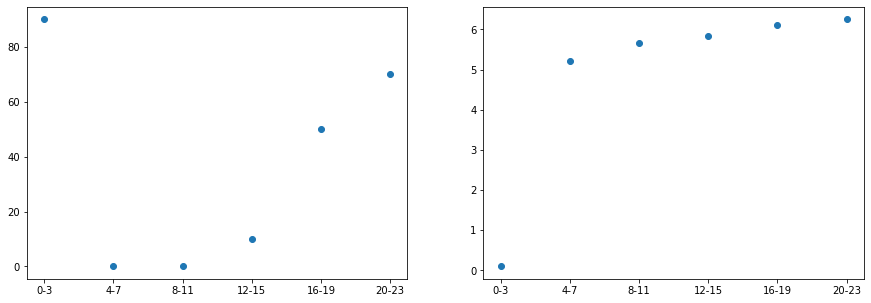

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))


ax1.scatter([i for i in d_count.keys()],d_count.values())
ax2.scatter([i for i in d.keys()],ratingPerBin)

#normalize it by participant/nr of focus session
#nr of messages received/nr of focus session
